Extracted items from xbox.zip: ['xbox']
Using folder: xbox_dataset\xbox
Files in the Xbox folder: ['achievements.csv', 'games.csv', 'history.csv', 'players.csv', 'prices.csv', 'purchased_games.csv']

Preview of purchased_games.csv:
   playerid                                            library
0    848738  [14711, 2128, 10783, 9118, 7235, 9637, 717236,...
1    848736  [707376, 747223, 550303, 620354, 734202, 74678...
2   1470783  [638932, 32551, 748147, 468697, 446682, 615753...
3    848735  [736287, 555825, 717258, 422060, 12645, 550263...
4    848739  [698325, 443814, 745210, 747223, 734202, 71154...

Preview of prices.csv:
   gameid    usd    eur    gbp  jpy     rub date_acquired
0    1253  19.99  19.99  15.99  NaN  1772.0    2025-02-22
1  727440  17.99  17.99  14.99  NaN  1595.0    2025-02-22
2  747995   4.79   4.79   3.99  NaN   425.0    2025-02-22
3  727135  17.99  17.99  14.99  NaN  1595.0    2025-02-22
4  748541  19.99  19.99  16.74  NaN  1772.0    2025-02-22

Merged Data Previ

C:\Users\Carsons\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


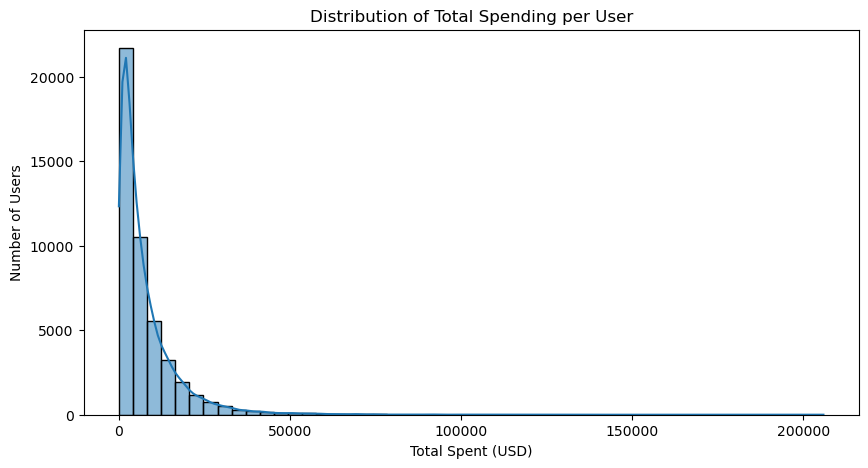

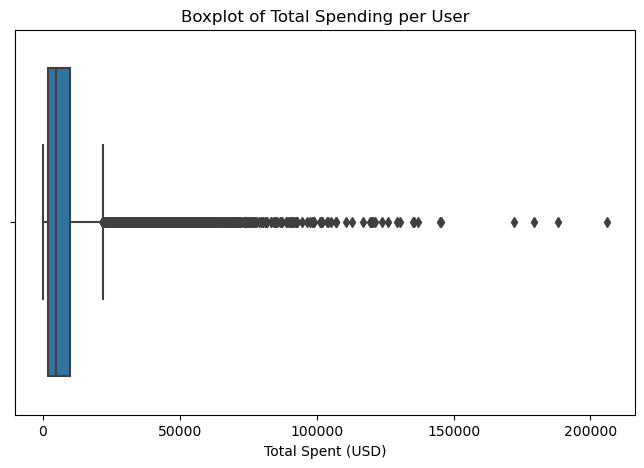


Top 10 Users by Spending:
       playerid  total_spent_usd
29522    848675        205928.25
29518    848671        188311.14
29492    848643        179358.98
29428    848573        171919.23
29455    848602        145420.96
29305    848415        145088.94
29516    848669        136906.06
29461    848608        135593.41
28760    847065        135317.72
28608    846410        130284.12

Random Forest Performance:
Mean Absolute Error: 1643.3651347498558
Mean Squared Error: 9330352.869530149
Root Mean Squared Error: 3054.562631462997

Gradient Boosting Performance:
Mean Absolute Error: 1539.9164579576013
Mean Squared Error: 7453991.14102127
Root Mean Squared Error: 2730.1998353639374


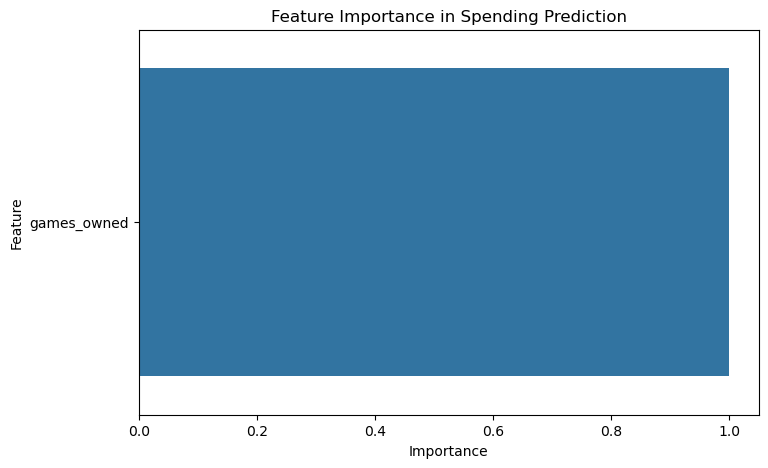

In [21]:
import zipfile
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to extract ZIP files
def extract_zip(zip_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    extracted_files = os.listdir(extract_dir)
    print(f"Extracted items from {zip_path}:", extracted_files)
    return extract_dir

# Function to find dataset folder
def find_dataset_folder(extract_dir):
    extracted_files = os.listdir(extract_dir)
    if len(extracted_files) == 1 and os.path.isdir(os.path.join(extract_dir, extracted_files[0])):
        return os.path.join(extract_dir, extracted_files[0])
    return extract_dir

# Extract Xbox dataset
xbox_zip_path = "xbox.zip"
xbox_extract_dir = "xbox_dataset"
xbox_folder = find_dataset_folder(extract_zip(xbox_zip_path, xbox_extract_dir))
print("Using folder:", xbox_folder)
print("Files in the Xbox folder:", os.listdir(xbox_folder))

# Load CSV files
def load_csv(file_name, folder):
    file_path = os.path.join(folder, file_name)
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print(f"Warning: {file_name} not found in {folder}")
        return None

purchased_games_df = load_csv("purchased_games.csv", xbox_folder)
prices_df = load_csv("prices.csv", xbox_folder)

if purchased_games_df is not None:
    print("\nPreview of purchased_games.csv:")
    print(purchased_games_df.head())
if prices_df is not None:
    print("\nPreview of prices.csv:")
    print(prices_df.head())

# Process data
if purchased_games_df is not None and prices_df is not None:
    purchased_games_df["library"] = purchased_games_df["library"].fillna("[]")
    purchased_games_df["library"] = purchased_games_df["library"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    purchased_games_exploded = purchased_games_df.explode("library")
    purchased_games_exploded.rename(columns={"library": "gameid"}, inplace=True)
    purchased_games_exploded["gameid"] = pd.to_numeric(purchased_games_exploded["gameid"], errors='coerce')
    prices_df["gameid"] = pd.to_numeric(prices_df["gameid"], errors='coerce')
    merged_df = purchased_games_exploded.merge(prices_df, on="gameid", how="left")

    print("\nMerged Data Preview:")
    print(merged_df.head())

    # Calculate user spending
    user_spending = merged_df.groupby("playerid")["usd"].sum().reset_index()
    user_spending.rename(columns={"usd": "total_spent_usd"}, inplace=True)
    print("\nUser Spending Summary:")
    print(user_spending.head())

    # Export data for Tableau
    user_spending.to_csv("user_spending.csv", index=False)
    print("Exported user_spending.csv for Tableau.")

    # Perform EDA
    print("\nMissing Values:")
    print(merged_df.isnull().sum())
    print("\nSummary Statistics:")
    print(merged_df.describe())

    # Plot spending distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(user_spending["total_spent_usd"], bins=50, kde=True)
    plt.title("Distribution of Total Spending per User")
    plt.xlabel("Total Spent (USD)")
    plt.ylabel("Number of Users")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.boxplot(x=user_spending["total_spent_usd"])
    plt.title("Boxplot of Total Spending per User")
    plt.xlabel("Total Spent (USD)")
    plt.show()

    top_spenders = user_spending.sort_values(by="total_spent_usd", ascending=False).head(10)
    print("\nTop 10 Users by Spending:")
    print(top_spenders)

    # Feature Engineering
    merged_df.fillna(0, inplace=True)
    features = merged_df.groupby("playerid").agg({"usd": "sum", "gameid": "count"}).reset_index()
    features.rename(columns={"usd": "total_spent", "gameid": "games_owned"}, inplace=True)

    # Prepare training data
    X = features.drop(columns=["playerid", "total_spent"])
    y = features["total_spent"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Models
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Performance:")
        print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
        print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
        print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))

    # Feature Importance
    feature_importances = pd.Series(models["Random Forest"].feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Feature Importance in Spending Prediction")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
